### Set up libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!pip install split-folders
!pip install -q -U keras-tuner
!pip install -U efficientnet
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import os, random

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
from keras_tuner import Hyperband
import efficientnet.keras as efn 

import matplotlib.pyplot as plt

from PIL import Image

import re

import splitfolders

import shutil

import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score

import cv2

from scikitplot.metrics import plot_confusion_matrix

### Delete as need be

In [5]:
##To be used as ncessary to remove any images from a specified folder in the event the subsequent code errors and doesn't complete the task
def delete(src):
  for i in os.listdir(src):
    for k in os.listdir(src + i + '/'):
        try:
          os.remove(src + i + '/' + k)
        except:
          continue

In [12]:
delete('/content/drive/MyDrive/691 Project Final/2. Renamed/')

### Re-name

In [15]:
#Defining a function that will copy the files from 'Raw' to 'Renamed', into their respective folder and rename them with type of image and count
def rename_files(src, dest):
  for i in os.listdir(src):
    count = 0
    for k in os.listdir(src + i):
        try:
          extension = os.path.splitext(k)[1]
          path = dest + i + '/' + k
          dst = dest + i + '/' + i + str(count) + extension
          dst_copy1 = dest + i + '/' + i + str(count+1) + extension
          dst_copy2 = dest + i + '/' + i + str(count+2) + extension
          
          if not os.path.exists(dest + i):
            os.makedirs(dest + i)
          shutil.copy(src + i + '/' + k, dest + i)
          os.rename(path, dst)

          img = Image.open(dst)
          img2 = img.copy()
          img2 = np.array(img2)
          img2 = cv2.flip(img2, 0)
          img2 = Image.fromarray(img2)
          img2.save(dst_copy1)

          img = Image.open(dst)
          img3 = img.copy()
          img3 = np.array(img3)
          img3 = cv2.flip(img3, 1)
          img3 = Image.fromarray(img3)
          img3.save(dst_copy2)

          count += 3
        except:
          print('Problem at: ', k)
          count += 3

In [16]:
rename_files(src='/content/drive/MyDrive/691 Project Final/1. Raw/', dest='/content/drive/MyDrive/691 Project Final/2. Renamed/')

In [17]:
#Checking to see what the count for each folder looks like
for i in os.listdir('/content/drive/MyDrive/691 Project Final/2. Renamed/'):
  print(f'{i}:  ',len(os.listdir('/content/drive/MyDrive/691 Project Final/2. Renamed/' + i + '/')))

dyed-lifted-polyps:   3000
.ipynb_checkpoints:   0
dyed-resection-margins:   3000
esophagitis:   3000
normal-cecum:   3000
normal-pylorus:   3000
normal-z-line:   3000
polyps:   3000
ulcerative-colitis:   3000


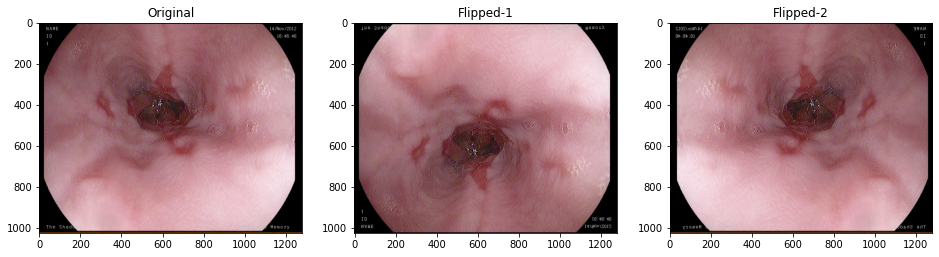

In [18]:
#Plotting to compare Original and Contrast images and histograms
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

#Assigning random image
img1 = Image.open('/content/drive/MyDrive/691 Project Final/2. Renamed/esophagitis/esophagitis0.jpg')
img2 = Image.open('/content/drive/MyDrive/691 Project Final/2. Renamed/esophagitis/esophagitis1.jpg')
img3 = Image.open('/content/drive/MyDrive/691 Project Final/2. Renamed/esophagitis/esophagitis2.jpg')

ax1.imshow(img1)
ax1.title.set_text('Original')
ax2.imshow(img2)
ax2.title.set_text('Flipped-1')
ax3.imshow(img3)
ax3.title.set_text('Flipped-2')

### Resize

In [19]:
#Defining a function that will call each image from 'Renamed', opens it, resizes it to 170x136 since all images aren't the same size and save them into each class 'Resize" folder.
def resize_images(src, dest):
  for i in os.listdir(src):
    for k in os.listdir(src + i):
      try:
        img = Image.open(src + i + '/' + k)
        new_img = img.resize((160, 128))
        if not os.path.exists(dest + i):
          os.makedirs(dest + i)
        new_img.save(dest + i + '/' + k, 'jpeg')
      except:
        print('Problem at: ', k)
        continue

In [20]:
resize_images(src='/content/drive/MyDrive/691 Project Final/2. Renamed/', dest='/content/drive/MyDrive/691 Project Final/3. Resized/')

In [21]:
#Checking to see what the count for each folder looks like
for i in os.listdir('/content/drive/MyDrive/691 Project Final/3. Resized/'):
  print(f'{i}:  ',len(os.listdir('/content/drive/MyDrive/691 Project Final/3. Resized/' + i + '/')))

dyed-lifted-polyps:   3000
.ipynb_checkpoints:   0
dyed-resection-margins:   3000
esophagitis:   3000
normal-cecum:   3000
normal-pylorus:   3000
normal-z-line:   3000
polyps:   3000
ulcerative-colitis:   3000


### Adjusting Contrast

In [22]:
#Defining a function that calls each image from 'Resize', opens it, converts it to YCrCb color format, this allows to split into base red, green, blue channels, which will then
#   have the historgrams for each color channel equalized to provide better contrast on the image.  Then save to their repective folder in 'Contrast' folder.
def hist_equal(src, dest):
  for i in os.listdir(src):
    for k in os.listdir(src + i):

      #Open image
      img = cv2.imread(src + i + '/' + k)

      #Convert from RGB to YCrCb
      new_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

      #Equalize the histograms of all 3 channels
      new_img[0, :, :] = cv2.equalizeHist(new_img[0, :, :])
      new_img[:, 0, :] = cv2.equalizeHist(new_img[:, 0, :])
      new_img[:, :, 0] = cv2.equalizeHist(new_img[:, :, 0])

      #Convert from YCrCb to RGB
      equal_img = cv2.cvtColor(new_img, cv2.COLOR_YCrCb2BGR)

      #If there isn't a directory by this name in the destination location then make one
      if not os.path.exists(dest + i):
          os.makedirs(dest + i)

      #Save
      cv2.imwrite(dest + i + '/' + k, equal_img)

In [23]:
hist_equal(src='/content/drive/MyDrive/691 Project Final/3. Resized/', dest='/content/drive/MyDrive/691 Project Final/4. Contrasted/')

In [24]:
#Checking to see what the count for each folder looks like
for i in os.listdir('/content/drive/MyDrive/691 Project Final/4. Contrasted/'):
  print(f'{i}:  ',len(os.listdir('/content/drive/MyDrive/691 Project Final/4. Contrasted/' + i + '/')))

dyed-lifted-polyps:   3000
dyed-resection-margins:   3000
esophagitis:   3000
normal-cecum:   3000
normal-pylorus:   3000
normal-z-line:   3000
polyps:   3000
ulcerative-colitis:   3000


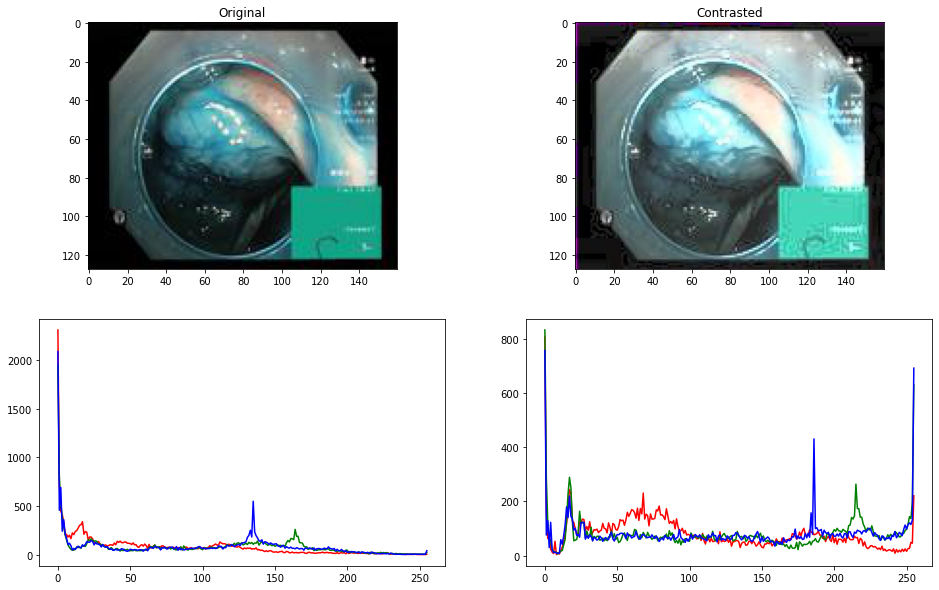

In [25]:
#Plotting to compare Original and Contrast images and histograms
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

#Choosing random image
dir = '/content/drive/MyDrive/691 Project Final/2. Renamed/'
i = random.choice(os.listdir(dir))
k = random.choice(os.listdir(dir + i))

#Assigning random image
img1 = Image.open('/content/drive/MyDrive/691 Project Final/3. Resized/' + i + '/' + k)
img2 = Image.open('/content/drive/MyDrive/691 Project Final/4. Contrasted/' + i + '/' + k)

ax1.imshow(img1)
ax1.title.set_text('Original')
ax2.imshow(img2)
ax2.title.set_text('Contrasted')

img1r, img1g, img1b = img1.split()
img2r, img2g, img2b = img2.split()

bins = list(range(256))

#Plotting histograms
ax3.plot(bins, img1r.histogram(), 'r')
ax3.plot(bins, img1g.histogram(), 'g')
ax3.plot(bins, img1b.histogram(), 'b')

ax4.plot(bins, img2r.histogram(), 'r')
ax4.plot(bins, img2g.histogram(), 'g')
ax4.plot(bins, img2b.histogram(), 'b')

plt.show()

### Quantize

In [26]:
#Defining a function that will call each file, opens it, and quantizes it down to the top K many colors.  This will help compress the image to just that which is needed to identify
#    and in theory allow for easier computation, thus faster modeling, and or more models to get through with limited resources.
def quantize(src, dest):
  for i in os.listdir(src):
    for k in os.listdir(src + i):
      try:
        img = Image.open(src + i + '/' + k)
        img.quantize(kmeans=4)
        if not os.path.exists(dest + i):
          os.makedirs(dest + i)
        img.save(dest + i + '/' + k, 'jpeg')
      except:
        continue

In [27]:
quantize(src='/content/drive/MyDrive/691 Project Final/4. Contrasted/', dest='/content/drive/MyDrive/691 Project Final/5. Quantize/')

In [28]:
for i in os.listdir('/content/drive/MyDrive/691 Project Final/5. Quantize/'):
  print(f'{i}:  ', len(os.listdir('/content/drive/MyDrive/691 Project Final/5. Quantize/' + i + '/')))

dyed-lifted-polyps:   3000
dyed-resection-margins:   3000
esophagitis:   3000
normal-cecum:   3000
normal-pylorus:   3000
normal-z-line:   3000
polyps:   3000
ulcerative-colitis:   3000


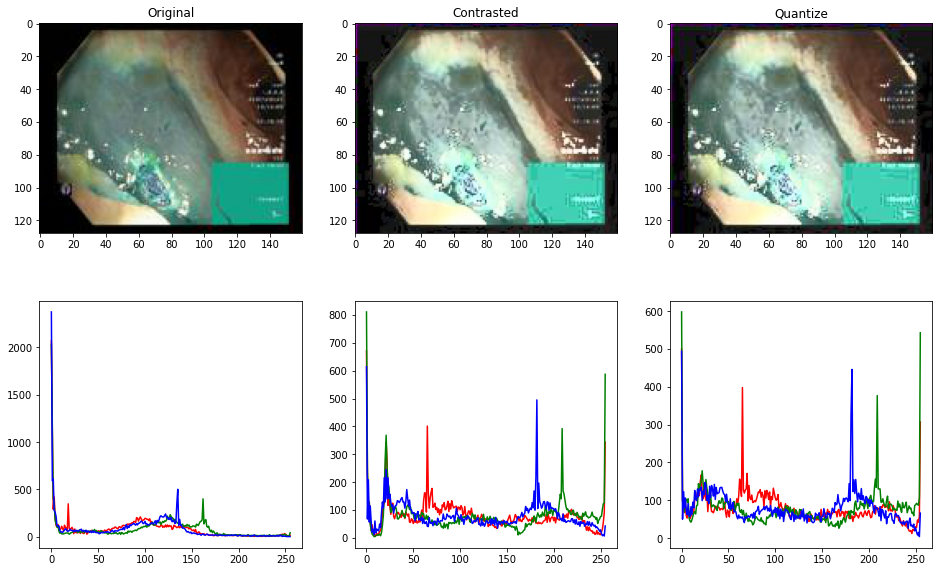

In [29]:
#Plotting to compare Original and Contrast images and histograms
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 10))

#Choosing random image
dir = '/content/drive/MyDrive/691 Project Final/2. Renamed/'
i = random.choice(os.listdir(dir))
k = random.choice(os.listdir(dir + i))

#Assigning random image
img1 = Image.open('/content/drive/MyDrive/691 Project Final/3. Resized/' + i + '/' + k)
img2 = Image.open('/content/drive/MyDrive/691 Project Final/4. Contrasted/' + i + '/' + k)
img3 = Image.open('/content/drive/MyDrive/691 Project Final/5. Quantize/' + i + '/' + k)

ax1.imshow(img1)
ax1.title.set_text('Original')
ax2.imshow(img2)
ax2.title.set_text('Contrasted')
ax3.imshow(img3)
ax3.title.set_text('Quantize')

img1r, img1g, img1b = img1.split()
img2r, img2g, img2b = img2.split()
img3r, img3g, img3b = img3.split()

bins = list(range(256))

#Plotting histograms
ax4.plot(bins, img1r.histogram(), 'r')
ax4.plot(bins, img1g.histogram(), 'g')
ax4.plot(bins, img1b.histogram(), 'b')

ax5.plot(bins, img2r.histogram(), 'r')
ax5.plot(bins, img2g.histogram(), 'g')
ax5.plot(bins, img2b.histogram(), 'b')

ax6.plot(bins, img3r.histogram(), 'r')
ax6.plot(bins, img3g.histogram(), 'g')
ax6.plot(bins, img3b.histogram(), 'b')

plt.show()

### Split

In [30]:
#Split the within folders into a train (80% of data), test (10%), and validation (10%)
splitfolders.ratio('/content/drive/MyDrive/691 Project Final/5. Quantize/', output='/content/drive/MyDrive/691 Project Final/6. Split/', seed=32, ratio=(.8, .1, .1), move=False)

Copying files: 24000 files [03:04, 129.96 files/s]


In [31]:
#Defining a function to determine how many of each file is in each test, train, val, and sub class type.
for i in os.listdir('/content/drive/MyDrive/691 Project Final/6. Split/'):
  print(f'{i}:  ',len(os.listdir('/content/drive/MyDrive/691 Project Final/6. Split/' + i + '/')))
  for k in os.listdir('/content/drive/MyDrive/691 Project Final/6. Split/' + i):
    print(f'   {k}:  ', len(os.listdir('/content/drive/MyDrive/691 Project Final/6. Split/' + i + '/' + k)))

train:   8
   dyed-lifted-polyps:   2400
   dyed-resection-margins:   2400
   esophagitis:   2400
   normal-cecum:   2400
   normal-pylorus:   2400
   normal-z-line:   2400
   polyps:   2400
   ulcerative-colitis:   2400
val:   8
   dyed-lifted-polyps:   300
   dyed-resection-margins:   300
   esophagitis:   300
   normal-cecum:   300
   normal-pylorus:   300
   normal-z-line:   300
   polyps:   300
   ulcerative-colitis:   300
test:   8
   dyed-lifted-polyps:   300
   dyed-resection-margins:   300
   esophagitis:   300
   normal-cecum:   300
   normal-pylorus:   300
   normal-z-line:   300
   polyps:   300
   ulcerative-colitis:   300
.ipynb_checkpoints:   0


### Assigning  train test val images

In [6]:
# Defining a function which calls each folder within the test, train, val folders and then calls each file within that, and assigns a label (0-7...8 classes total)to the label 
#    list based on it's name having it's class name within.
def labels(src):
    all_images = []
    label = []
    for i in os.listdir(src):
      for k in os.listdir(src + i):
        try:
          if re.match(r'dyed-lifted-polyps', k):
              label.append(0)
          elif re.match(r'dyed-resection-margins', k):
              label.append(1)
          elif re.match(r'esophagitis', k):
              label.append(2)
          elif re.match(r'normal-cecum', k):
              label.append(3)
          elif re.match(r'normal-pylorus', k):
              label.append(4)
          elif re.match(r'normal-z-line', k):
              label.append(5)
          elif re.match(r'polyps', k):
              label.append(6)
          elif re.match(r'ulcerative-colitis', k):
              label.append(7)
          img = Image.open(src + i + '/' + k)
          img_array = np.asarray(img)
          all_images.append(img_array)
        except:
          continue
    return np.array(all_images), np.array(label)

In [7]:
#Calling the function above for each test, train, val folder to create the X_test/train/val sets and y_train/tst/val sets.
path_to_train_set = '/content/drive/MyDrive/691 Project Final/6. Split/train/'
path_to_test_set = '/content/drive/MyDrive/691 Project Final/6. Split/test/'
path_to_val_set = '/content/drive/MyDrive/691 Project Final/6. Split/val/'

X_train, y_train = labels(path_to_train_set)
X_test, y_test = labels(path_to_test_set)
X_val, y_val = labels(path_to_val_set)

print('X_train set : ', X_train)
print('y_train set : ', y_train)
print('X_test set : ', X_test)
print('y_test set : ', y_test)
print('X_val set: ', X_val)
print('y_val set: ', y_val)

X_train set :  [[[[248  37 255]
   [208  37 230]
   [196  79 212]
   ...
   [146  55 176]
   [146  55 176]
   [146  55 176]]

  [[167   0 189]
   [107   0 123]
   [ 74   0  83]
   ...
   [ 48   0  68]
   [ 48   0  68]
   [ 48   0  68]]

  [[156  36 170]
   [ 76   0  85]
   [ 29   3  32]
   ...
   [ 11   2  19]
   [ 11   2  19]
   [ 11   2  19]]

  ...

  [[195  45 196]
   [ 89   0  95]
   [ 47  28  56]
   ...
   [ 11  11  11]
   [  9   9   9]
   [ 13  13  13]]

  [[195  45 196]
   [ 89   0  95]
   [ 47  28  56]
   ...
   [ 11  11  11]
   [  9   9   9]
   [ 13  13  13]]

  [[195  45 196]
   [ 89   0  95]
   [ 47  28  56]
   ...
   [ 11  11  11]
   [  9   9   9]
   [ 13  13  13]]]


 [[[167  32 194]
   [101   3 122]
   [ 69  24  83]
   ...
   [131  45 144]
   [131  45 144]
   [132  44 146]]

  [[142  13 168]
   [ 71   0  92]
   [ 33   0  46]
   ...
   [ 57   0  67]
   [ 57   0  67]
   [ 58   0  69]]

  [[145  23 170]
   [ 66   0  86]
   [ 24   0  35]
   ...
   [ 26   0  32]
   [ 26   0  

In [8]:
#Printing the shape fo the X and y datasets to determine that these are proper ratios through execution of the function above.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(19200, 128, 160, 3) (19200,)
(2400, 128, 160, 3) (2400,)
(2400, 128, 160, 3) (2400,)


In [9]:
#Assigning class names to association with the label names.  This will make it easier when we get to predictions to refer to teh class name rather than label name.
class_names = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 
               'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

### Preprocessing images for the model

In [10]:
#Last step of preprocessing to ensure that all of the color ranges are between 0 and 1 for modeling.
X_train_mod = X_train.astype('float32') / 255.0
X_test_mod = X_test.astype('float32') / 255.0
X_val_mod = X_val.astype('float32') / 255.0

X_train_mod = X_train_mod.reshape(-1, 128, 160, 3)
y_train_mod = np.array(y_train)

X_test_mod = X_test_mod.reshape(-1, 128, 160, 3)
y_test_mod = np.array(y_test)

X_val_mod = X_val_mod.reshape(-1, 128, 160, 3)
y_val_mod = np.array(y_val)

In [11]:
print(X_train_mod.shape, y_train.shape)
print(X_test_mod.shape, y_test.shape)
print(X_val_mod.shape, y_val.shape)

(19200, 128, 160, 3) (19200,)
(2400, 128, 160, 3) (2400,)
(2400, 128, 160, 3) (2400,)


### Exploration of the images

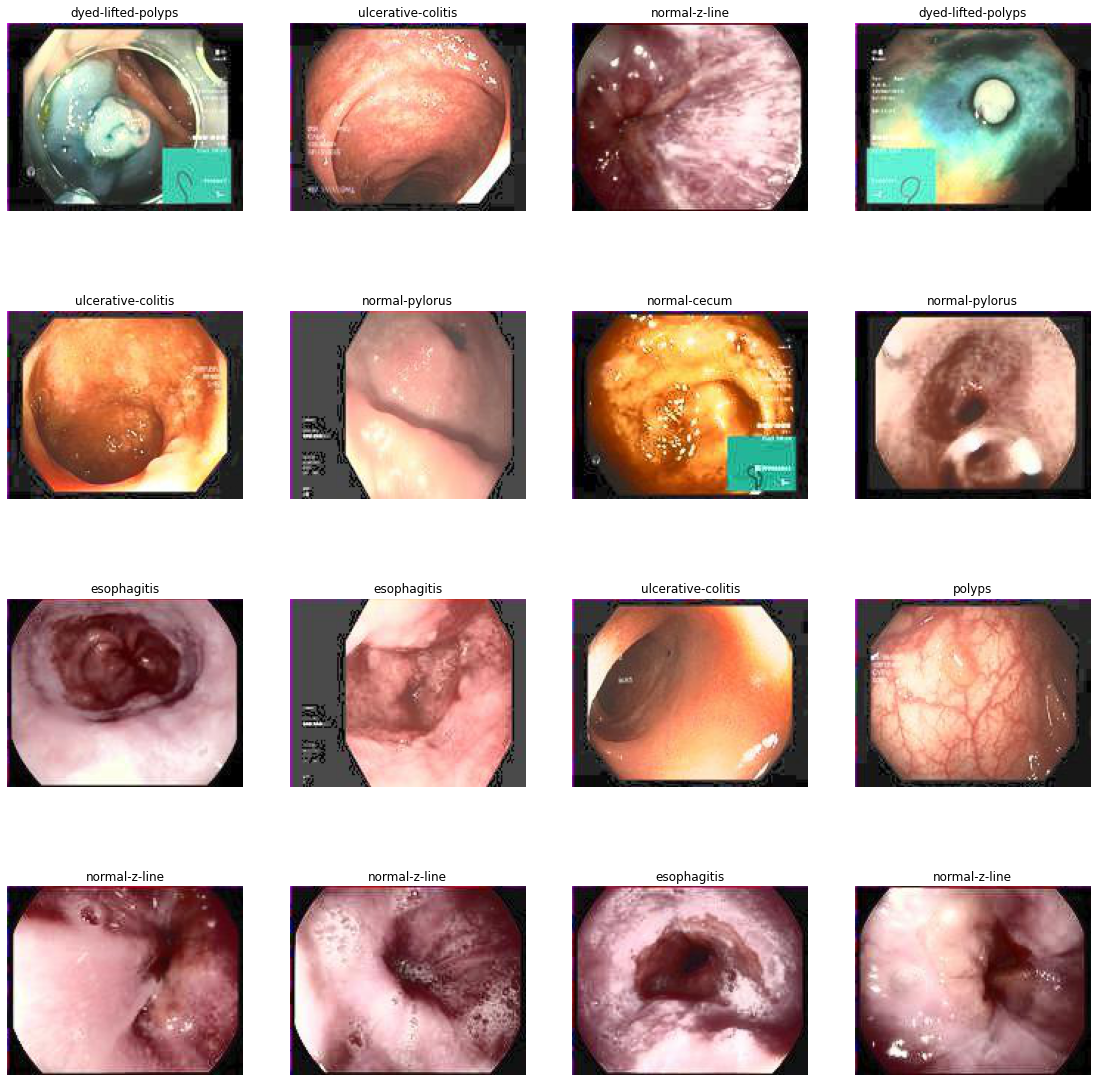

In [12]:
#Calling 16 random images from the X_train_mod dataset to ensure that they are able to be called, giving confidence to pulling these into the model, and showing that the 
#    classnames are working when calling labels.
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols*4.854, n_rows * 4.854))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    rando = np.random.randint(0, len(X_train_mod))
    plt.imshow(X_train_mod[rando], cmap='gray')
    plt.axis('off')
    plt.title(class_names[y_train_mod[rando]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### First run hyperparameter tuning

In [18]:
#Calling the EfficientNetB7 Convolutional Neural Network (CNN)
eff_net = efn.EfficientNetB7(
    weights='imagenet',
    input_shape=(128, 160, 3),
    include_top=False,
    pooling='max')

In [19]:
#Defining the first model, which is rough in nature and will be refined in further models.  This will determine if we can find extra accuracy beyond the EfficientNet alone.
def mod1(hp):
  model = keras.models.Sequential()
  
  model.add(eff_net)

  for i in range(hp.Int('layers', min_value=6, max_value=6, step=1)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=545, step=64), activation='relu'))

  model.add(keras.layers.Dense(units=64, activation='relu'))
  model.add(keras.layers.Dense(units=32, activation='relu'))
  model.add(keras.layers.Dense(units=16, activation='relu'))
    
  model.add(keras.layers.Dense(8, activation="softmax"))

  model.compile(optimizer=keras.optimizers.Adam(), 
                loss = keras.losses.SparseCategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  return model

In [20]:
#Calling the Hperband to tune hyperparameters above.
tuner1 = kt.Hyperband(
    mod1,
    objective='val_accuracy',
    overwrite=True,
    directory='my_dir',
    project_name='endoscopy')

In [21]:
#Building an early stop function and searching the for hyperparameter optimization.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner1.search(X_train_mod, y_train_mod,
              validation_data=(X_val_mod, y_val_mod),
              epochs=250,
               callbacks=[early_stop],
              use_multiprocessing=True)

Trial 10 Complete [00h 06m 19s]
val_accuracy: 0.9154166579246521

Best val_accuracy So Far: 0.9154166579246521
Total elapsed time: 01h 00m 09s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
6                 |6                 |layers
544               |544               |units_0
288               |96                |units_1
224               |544               |units_2
224               |160               |units_3
544               |32                |units_4
544               |288               |units_5
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: ignored

### HP Refinement #1

In [22]:
def mod2(hp):
  model = keras.models.Sequential()
  
  model.add(eff_net)

  model.add(keras.layers.Dense(units=hp.Int('units_' + str(0), min_value=544, max_value=553, step=4), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(1), min_value=92, max_value=101, step=4), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(2), min_value=544, max_value=553, step=4), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(3), min_value=156, max_value=165, step=4), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(4), min_value=21, max_value=33, step=4), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(5), min_value=284, max_value=293, step=4), activation='relu'))

  model.add(keras.layers.Dense(units=64, activation='relu'))
  model.add(keras.layers.Dense(units=32, activation='relu'))
  model.add(keras.layers.Dense(units=16, activation='relu'))

  model.add(keras.layers.Dense(8, activation="softmax"))

  model.compile(optimizer=keras.optimizers.Adam(), 
                loss = keras.losses.SparseCategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  return model

In [23]:
tuner2 = kt.Hyperband(
    mod2,
    objective='val_accuracy',
    overwrite=True,
    directory='my_dir',
    project_name='endoscopy2' )

In [24]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner2.search(X_train_mod, y_train_mod,
              validation_data=(X_val_mod, y_val_mod),
              epochs=250,
              callbacks=[early_stop], 
              use_multiprocessing=True)

Trial 10 Complete [00h 05m 59s]
val_accuracy: 0.9191666841506958

Best val_accuracy So Far: 0.9291666746139526
Total elapsed time: 01h 02m 14s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
544               |544               |units_0
96                |96                |units_1
552               |544               |units_2
156               |160               |units_3
21                |29                |units_4
284               |284               |units_5
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: ignored

### HP Refinement #2

In [25]:
def mod3(hp):
  model = keras.models.Sequential()
  
  model.add(eff_net)

  model.add(keras.layers.Dense(units=hp.Int('units_' + str(0), min_value=540, max_value=544, step=1), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(1), min_value=94, max_value=98, step=1), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(2), min_value=540, max_value=544, step=1), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(3), min_value=158, max_value=162, step=1), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(4), min_value=27, max_value=31, step=1), activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units_' + str(5), min_value=282, max_value=286, step=1), activation='relu'))

  model.add(keras.layers.Dense(units=64, activation='relu'))
  model.add(keras.layers.Dense(units=32, activation='relu'))
  model.add(keras.layers.Dense(units=16, activation='relu'))

  model.add(keras.layers.Dense(8, activation="softmax"))

  model.compile(optimizer=keras.optimizers.Adam(), 
                loss = keras.losses.SparseCategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  return model

In [26]:
tuner3 = kt.Hyperband(
    mod3,
    objective = 'val_accuracy',
    overwrite=True,
    directory = 'my_dir',
    project_name="endoscopy3"   
)

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner3.search(X_train_mod, y_train_mod,
              validation_data=(X_val_mod, y_val_mod),
              epochs=250,
              callbacks=[early_stop], 
              use_multiprocessing=True)

Trial 10 Complete [00h 06m 01s]
val_accuracy: 0.9283333420753479

Best val_accuracy So Far: 0.9350000023841858
Total elapsed time: 00h 59m 36s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
544               |544               |units_0
96                |96                |units_1
543               |543               |units_2
161               |161               |units_3
31                |27                |units_4
283               |286               |units_5
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: ignored

### Model finishing

In [28]:
best_hps = tuner3.get_best_hyperparameters(num_trials=1)[0]

model = tuner3.hypermodel.build(best_hps)

In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(X_train_mod, y_train_mod,
             validation_data=(X_val_mod, y_val_mod),
             epochs=250,
             callbacks=[early_stop], 
             use_multiprocessing=True)

Epoch 1/250
600/600 [==============================] - 234s 185ms/step - loss: 0.1027 - accuracy: 0.9701 - val_loss: 0.5031 - val_accuracy: 0.9137
Epoch 2/250
600/600 [==============================] - 107s 178ms/step - loss: 0.0658 - accuracy: 0.9855 - val_loss: 0.4827 - val_accuracy: 0.9158
Epoch 3/250
600/600 [==============================] - 107s 178ms/step - loss: 0.0556 - accuracy: 0.9874 - val_loss: 0.3766 - val_accuracy: 0.9154
Epoch 4/250
600/600 [==============================] - 107s 178ms/step - loss: 0.0377 - accuracy: 0.9912 - val_loss: 0.4123 - val_accuracy: 0.9275
Epoch 5/250
600/600 [==============================] - 107s 178ms/step - loss: 0.0326 - accuracy: 0.9922 - val_loss: 0.3607 - val_accuracy: 0.9287
Epoch 6/250
600/600 [==============================] - 107s 178ms/step - loss: 0.1444 - accuracy: 0.9690 - val_loss: 0.3470 - val_accuracy: 0.9179
Epoch 7/250
600/600 [==============================] - 107s 179ms/step - loss: 0.0505 - accuracy: 0.9889 - val_loss: 0

In [30]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch:  {best_epoch}')

Best epoch:  5


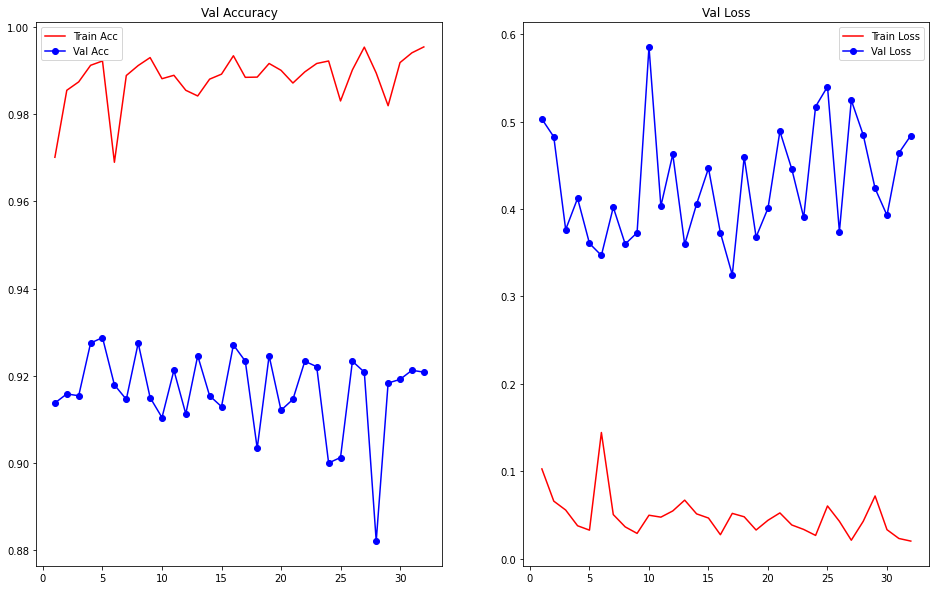

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1.plot(epochs, acc, 'r', label = 'Train Acc')
ax1.plot(epochs, val_acc, 'bo-', label = 'Val Acc')
ax1.title.set_text('Val Accuracy')
ax1.legend()
ax2.plot(epochs, loss, 'r', label = 'Train Loss')
ax2.plot(epochs, val_loss, 'bo-', label = 'Val Loss')
ax2.title.set_text('Val Loss')
ax2.legend()

plt.show()

In [32]:
#Predicting the X_test_mod to compare to y_test_mod
y_pred = model.predict(X_test_mod)

75/75 [==============================] - 8s 40ms/step


In [33]:
y_pred

array([[9.9922478e-01, 7.6710933e-04, 1.0944724e-25, ..., 1.4123090e-21,
        8.0585023e-06, 4.0203249e-10],
       [1.0000000e+00, 1.6089538e-11, 0.0000000e+00, ..., 0.0000000e+00,
        3.0988199e-19, 3.8704120e-34],
       [1.0000000e+00, 5.3032926e-14, 0.0000000e+00, ..., 0.0000000e+00,
        1.4320728e-23, 0.0000000e+00],
       ...,
       [5.0970106e-10, 7.2933430e-12, 1.6017022e-07, ..., 2.3853228e-11,
        3.5557925e-05, 9.9992096e-01],
       [5.0695658e-18, 2.8791522e-21, 2.9015240e-13, ..., 2.2621419e-20,
        2.7988867e-09, 1.0000000e+00],
       [1.2348891e-19, 3.6593825e-23, 2.0194711e-14, ..., 3.4346716e-22,
        4.1699608e-10, 1.0000000e+00]], dtype=float32)

In [34]:
#The y_pred is giving softmax of 8 classes, so getting the value in the set with the highest 'probability' and assigning it to the y_pred_mod list.
y_pred_mod = []
for i in y_pred:
  y_pred_mod.append(np.argmax(i))

In [35]:
#Determining the accurracy, precision, recall, and F1 score for the y+pred_mod vs. y_test_mod sets.
acc = round(sklearn.metrics.accuracy_score(y_test_mod, y_pred_mod)*100, 2)
prec = (sklearn.metrics.precision_score(y_test_mod, y_pred_mod, average=None)*100).round(2)
rec = (sklearn.metrics.recall_score(y_test_mod, y_pred_mod, average=None)*100).round(2)
f1 = (sklearn.metrics.f1_score(y_test_mod, y_pred_mod, average=None)*100).round(2)

In [36]:
#Printing results from above.
#Precision = TP / (TP+FP), this is per class
#Recall = TP / (TP+FN)
#F1 = 2 x(Precision * Recall) / (Precision + Recall)
print(f'Accuracy is: {acc}')
print(f'Precision is: {prec}')
print(f'Recall is: {rec}')
print(f'F1 is: {f1}')

Accuracy is: 92.33
Precision is: [94.98 94.68 83.57 97.05 94.34 80.84 97.17 96.  ]
Recall is: [ 94.67  95.    79.67  98.67 100.    83.    91.67  96.  ]
F1 is: [94.82 94.84 81.57 97.85 97.09 81.91 94.34 96.  ]


dyed-lifted-polyps - 0
dyed-resection-margins - 1
esophagitis - 2
normal-cecum - 3
normal-pylorus - 4
normal-z-line - 5
polyps - 6
ulcerative-colitis - 7


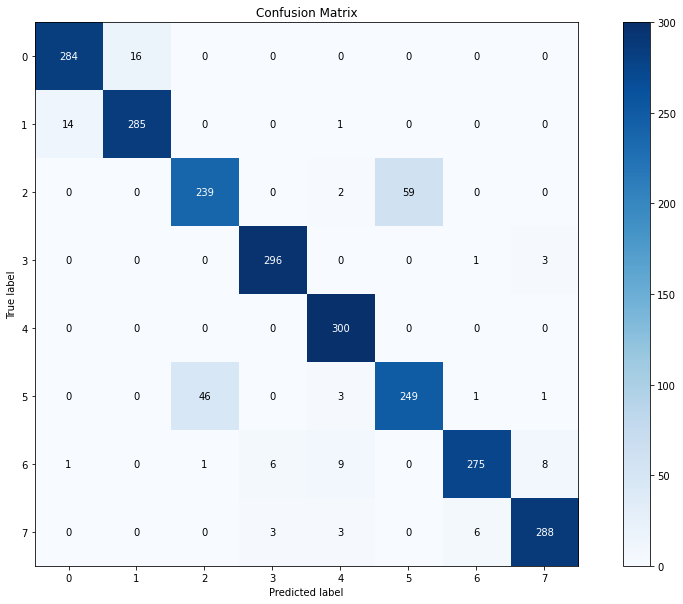

In [37]:
#Showing the confusion matrix to see where we the sticking points were in the model.
for i in class_names:
  print(i, '-', class_names.index(i))
fig, ax = plt.subplots(figsize=(16,10))
plot_confusion_matrix(y_test_mod, y_pred_mod, ax=ax)

### Save Model

In [38]:
model.save('/content/drive/MyDrive/691 Project Final/endoscopy_modelv6.h5')